In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F

## Define Sample Data

In [3]:
corpus = ["apple banana fruit", "banana apple fruit", "banana fruit apple",
                 "dog cat animal", "cat animal dog", "cat dog animal"]

In [4]:
corpus = [sent.split(" ") for sent in corpus]
corpus

[['apple', 'banana', 'fruit'],
 ['banana', 'apple', 'fruit'],
 ['banana', 'fruit', 'apple'],
 ['dog', 'cat', 'animal'],
 ['cat', 'animal', 'dog'],
 ['cat', 'dog', 'animal']]

In [5]:
#extracting unique words
flatten = lambda l: [item for sublist in l for item in sublist]
vocab = list(set(flatten(corpus)))
vocab

['fruit', 'cat', 'apple', 'animal', 'banana', 'dog']

In [6]:
#appending number for each word in the set
word2index = {w: i for i, w in enumerate(vocab)}
print(word2index)

{'fruit': 0, 'cat': 1, 'apple': 2, 'animal': 3, 'banana': 4, 'dog': 5}


In [7]:
#vocab size
voc_size = len(vocab)
print(voc_size)

6


In [8]:
#append UNK
vocab.append('<UNK>')

In [9]:
vocab

['fruit', 'cat', 'apple', 'animal', 'banana', 'dog', '<UNK>']

In [10]:
#defining a method to get the word through index
index2word = {v:k for k, v in word2index.items()} 

## Data Preparation

In [11]:
def random_batch(batch_size, word_sequence):
    
    # Make skip gram of one size window
    skip_grams = []
    for sent in corpus:
        for i in range(1, len(sent) - 1):
            target = word2index[sent[i]]
            context = [word2index[sent[i - 1]], word2index[sent[i + 1]]]
            for w in context:
                skip_grams.append([target, w])
    
    random_inputs = []
    random_labels = []
    random_index = np.random.choice(range(len(skip_grams)), batch_size, replace=False) #randomly pick without replacement
        
    for i in random_index:
        random_inputs.append([skip_grams[i][0]])  # target, e.g., 2
        random_labels.append([skip_grams[i][1]])  # context word, e.g., 3
            
    return np.array(random_inputs), np.array(random_labels)

In [12]:
#testing the method
batch_size = 2 # mini-batch size
input_batch, target_batch = random_batch(batch_size, corpus)

print("Input: ",  input_batch)
print("Target: ", target_batch)

Input:  [[1]
 [0]]
Target:  [[3]
 [2]]


In [13]:
input_batch.shape, target_batch.shape

((2, 1), (2, 1))

## Negative Sampling
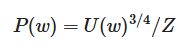

In [14]:
Z = 0.001


In [15]:
from collections import Counter

word_count = Counter(flatten(corpus))
num_total_words = sum([c for w, c in word_count.items()])

In [16]:
word_count[',']

0

In [17]:
unigram_table = []

for vo in vocab:
    unigram_table.extend([vo] * int(((word_count[vo]/num_total_words)**0.75)/Z))

In [18]:
Counter(unigram_table)

Counter({'fruit': 260,
         'cat': 260,
         'apple': 260,
         'animal': 260,
         'banana': 260,
         'dog': 260})

In [19]:
import random

def prepare_sequence(seq, word2index):
    idxs = list(map(lambda w: word2index[w] if word2index.get(w) is not None else word2index["<UNK>"], seq))
    return torch.LongTensor(idxs)

def negative_sampling(targets, unigram_table, k):
    batch_size = targets.size(0)
    neg_samples = []
    for i in range(batch_size):
        nsample = []
        target_index = targets[i].item()
        while len(nsample) < k: # num of sampling
            neg = random.choice(unigram_table)
            if word2index[neg] == target_index:
                continue
            nsample.append(neg)
        neg_samples.append(prepare_sequence(nsample, word2index).view(1, -1))
    return torch.cat(neg_samples)

In [20]:
input_batch  = torch.Tensor(input_batch)
target_batch = torch.LongTensor(target_batch)

In [21]:
target_batch.shape

torch.Size([2, 1])

In [22]:
num_neg = 3
negative_sampling(target_batch, unigram_table, num_neg)

tensor([[4, 0, 0],
        [5, 3, 5]])

In [23]:
target_batch[1]

tensor([2])

## Model

In [24]:
class SkipgramNegSampling(nn.Module):
    
    def __init__(self, vocab_size, emb_size):
        super(SkipgramNegSampling, self).__init__()
        self.embedding_v = nn.Embedding(vocab_size, emb_size) # center embedding
        self.embedding_u = nn.Embedding(vocab_size, emb_size) # out embedding
        self.logsigmoid = nn.LogSigmoid()
                    
    def forward(self, center_words, target_words, negative_words):
        center_embeds = self.embedding_v(center_words) # [batch_size, 1, emb_size]
        target_embeds = self.embedding_u(target_words) # [batch_size, 1, emb_size]
        neg_embeds    = -self.embedding_u(negative_words) # [batch_size, num_neg, emb_size]
        
        positive_score = target_embeds.bmm(center_embeds.transpose(1, 2)).squeeze(2)
        #[batch_size, 1, emb_size] @ [batch_size, emb_size, 1] = [batch_size, 1, 1] = [batch_size, 1]
        
        negative_score = neg_embeds.bmm(center_embeds.transpose(1, 2))
        #[batch_size, k, emb_size] @ [batch_size, emb_size, 1] = [batch_size, k, 1]
        
        loss = self.logsigmoid(positive_score) + torch.sum(self.logsigmoid(negative_score), 1)
                
        return -torch.mean(loss)
    
    def prediction(self, inputs):
        embeds = self.embedding_v(inputs)
        
        return embeds

## Training

In [25]:
batch_size     = 2 # mini-batch size
embedding_size = 2 #so we can later plot
model          = SkipgramNegSampling(voc_size, embedding_size)
num_neg        = 10 # num of negative sampling

optimizer = optim.Adam(model.parameters(), lr=0.001)